In [2]:
import os
import numpy as np
import hdf5storage as sio

nn_path = os.environ['NEURONUMBA_PATH']

# Load connectivity data
conn_66 = sio.loadmat(os.path.join(nn_path, "data", "h66.mat"))
weights = conn_66['weights']
tract_lengths = conn_66['tract_lengths']

n_rois = weights.shape[0]
print(f'Number of regions of interest = {n_rois}')

Number of regions of interest = 66


In [3]:
from neuronumba.simulator.models import Naskar
from neuronumba.simulator.connectivity import Connectivity

# Create the connectivity data for the simulation
con = Connectivity(weights=weights, lengths=tract_lengths, speed=1e10)
# Use the Naskar model
m = Naskar()
print(f"Naskar state variables = {m.get_state_vars}, and observable variables = {m.get_observablevars}")

Naskar state variables = {'S_e': 0, 'S_i': 1, 'J': 2}, and observable variables = {'Ie': 0, 're': 1}


In [4]:
from neuronumba.simulator.monitors import RawSubSample
from neuronumba.simulator.coupling import CouplingNoDelays
from neuronumba.simulator.integrators import EulerStochastic, EulerDeterministic

# Set integration step at 0.1 ms
dt = 0.1
# You can use an Euler integrator, either deterministic or stochastic
integ = EulerDeterministic(dt=dt)
# integ = EulerStochastic(dt=dt, sigmas=np.r_[1e-2, 0, 0])


# We are using a coupling with no delays, and with a global coupling linear factor of 1.0
coupling = CouplingNoDelays(weights=weights, c_func=m.get_numba_coupling(1.0))
# We want to sample observable variable 're' (firing rate) every 1 ms
obs_var = 're'
monitor = RawSubSample(period=1.0, state_vars=m.get_state_sub(), obs_vars=m.get_observed_sub([obs_var]))

In [5]:
import time
from neuronumba.simulator.simulator import Simulator

# Create the simulator
s = Simulator(connectivity=con, model=m, coupling=coupling, integrator=integ, monitors=[monitor])

# And run it measuring the execution time
# We run a simulation of 10 sec (100000 ms)
start_time = time.perf_counter()
s.run(0, 100000)
t_sim = time.perf_counter() - start_time
print(f"Simulation time = {t_sim} seconds")

Simulation time = 3.807003924000128 seconds


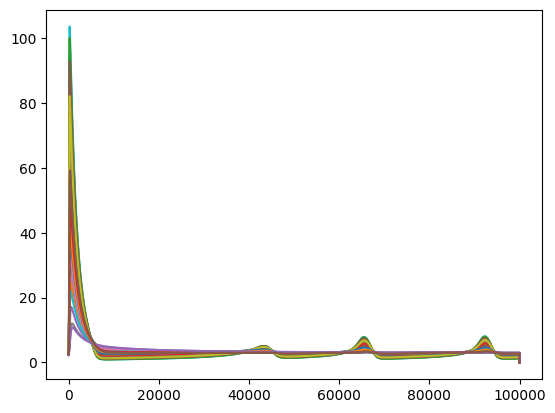

In [6]:
from matplotlib import pyplot as plt

signal = monitor.data(obs_var)

fig, ax = plt.subplots()
ax.plot(np.arange(signal.shape[0]), signal)
plt.show()

In [7]:
from neuronumba.bold.filters import BandPassFilter
from neuronumba.bold import BoldStephan2008

# Compute the bold signal from the simulation data
b = BoldStephan2008()
bold = b.compute_bold(signal, monitor.period)
# Apply a band pass filter
bpf = BandPassFilter(k=2, flp=0.01, fhi=0.1, tr=2.0)
# VERY IMPORTANT: signal from the simulator si returned with shape (n_time_samples, n_rois),
# but, for performance reasons, the filter expects it in the transposed form (n_rois, n_time_samples).
# We have to transpose it before passing it
bold_filt = bpf.filter(bold.T)

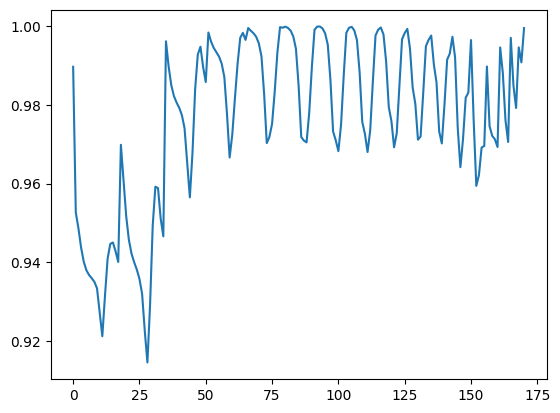

In [9]:


from neuronumba.observables.measures import KolmogorovSmirnovStatistic
from neuronumba.observables.ph_fcd import PhFCD

ph_fcd = PhFCD()
# Compute the measure from teh filtered bold signal
# IMPORTANT: from_fmri() method expects a signal with shape (n_rois, n_time_samples)
simulated = ph_fcd.from_fmri(bold_filt)
signal = simulated['phFCD']

# from_fmri() method always return a dictionary with the results
fig, ax = plt.subplots()
ax.plot(np.arange(signal.shape[0]), signal)
plt.show()